In [1]:
import ross as rs
import numpy as np
import math
from scipy.optimize import least_squares 
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import pickle
import plotly
import matplotlib.pyplot as plt

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#--------------------------------------- define "real" rotor and simulated rotor----------------------------------------
steel = rs.Material(name="Steel", rho=7810, E=211e9, G_s=81.2e9)

n = 2

shaft_elem = [
    rs.ShaftElement(
        L=0.25,
        idl=0.0,
        odl=0.05,
        material=steel,
        shear_effects=True,
        rotary_inertia=True,
        gyroscopic = True
    )
    for _ in range(n)
]

disk0 = rs.DiskElement.from_geometry(
    n=1, material=steel, width=0.07, i_d=0.05, o_d=0.28
)

disks = [disk0]

stfx_real = 1e6
stfy_real = 0.8e6
dampx_real = 5e3
dampy_real = 5e3
bearing0_real = rs.BearingElement(0, kxx=stfx_real, kyy=stfy_real, cxx = dampx_real, cyy = dampy_real)
bearing1_real = rs.BearingElement(2, kxx=stfx_real, kyy=stfy_real, cxx = dampx_real, cyy = dampy_real)

bearings_real = [bearing0_real, bearing1_real]

rotor_real = rs.Rotor(shaft_elem, disks, bearings_real)

stfx_sim = 1e6
stfy_sim = 1e6
bearing0_sim = rs.BearingElement(0, kxx=stfx_sim, kyy=stfy_sim, cxx = 0, cyy = 0)
bearing1_sim = rs.BearingElement(2, kxx=stfx_sim, kyy=stfy_sim, cxx = 0, cyy = 0)

bearings_sim = [bearing0_sim, bearing1_sim]

rotor_sim = rs.Rotor(shaft_elem, disks, bearings_sim)

# plotting rotor model

fig_rotor_real = rotor_real.plot_rotor()
fig_rotor_real.write_image("rotor_diagram.png")

In [3]:
#---------------------------------------- important variables-----------------------------------------------------------
SAMPLES = 61
FREQUENCY_RANGE = np.linspace(315, 1150, SAMPLES)
DISK_NODE = 1
SIGMA_TRUE = 0.01 
IMBALANCE_MAGNITUDE = 0.03
IMBALANCE_PHASE = 0

In [4]:
#-------------------------------------------return imbalance frequency response-----------------------------------------
def getImbalanceResponse(rotor_model, obs_node, magnitude, phase, frequency_range):
    '''
    rotor_model: the rotor object defined using ROSS library
    obs_node: node at which imbalance force is to be applied
    magnitude: magnitude of imbalance
    phase: phase of imbalance (Radians)
    frequency_range: range of frequencies which are being considered
    return:
        results: a results object
        fr: a matrix of the magnitudes and phases in the x and y directions
    '''
    probex = (1, 0)
    probey = (1, 90)

    results = rotor_model.run_unbalance_response(obs_node, magnitude, phase, frequency_range)
    x_mag = results.data_magnitude(probe=[probex], probe_units="degrees").loc[:, 'Probe 1 - Node 1'].values
    x_phase = results.data_phase(probe=[probex], probe_units="degrees").loc[:, 'Probe 1 - Node 1'].values
    y_mag = results.data_magnitude(probe=[probey], probe_units="degrees").loc[:, 'Probe 1 - Node 1'].values
    y_phase = results.data_phase(probe=[probey], probe_units="degrees").loc[:, 'Probe 1 - Node 1'].values
    fr = np.vstack((x_mag, x_phase, y_mag, y_phase)).T

    return results, fr

In [17]:
#---------------------------------------- real imbalance response-------------------------------------------------------
samples = 61
results_real, fr_real = getImbalanceResponse(rotor_real, DISK_NODE, IMBALANCE_MAGNITUDE, IMBALANCE_PHASE, FREQUENCY_RANGE)

# noise
epsilon = np.random.randn(SAMPLES, 4) * SIGMA_TRUE
observations = fr_real + epsilon

# plot real response
probe_real = (1, 0)
fig_results_real = results_real.plot_magnitude(probe = [probe_real], probe_units="degrees")
fig_results_real.update_layout(showlegend=False)
fig_results_real.show()
# fig_results_real.write_image("fr_real_phase.png")

In [18]:
#-------------------------------------- simulated imbalance response----------------------------------------------------
results_sim, fr_sim = getImbalanceResponse(rotor_sim, DISK_NODE, IMBALANCE_MAGNITUDE, IMBALANCE_PHASE, FREQUENCY_RANGE)
# plot sim response
probe_sim = (1, 0)
fig_results_sim = results_sim.plot_magnitude(probe = [probe_sim], probe_units="degrees")
fig_results_sim.update_layout(showlegend=False)
fig_results_sim.update_layout(yaxis_tickformat = '.3f')

# fig_results_sim.show()
# fig_results_sim.write_image("fr_sim_phase.png")

In [7]:
#-------------------------------------- least-squares method-------------------------------------------------------
beta_0 = [0,0]
def residuals(beta):
    mag = beta[0]
    ph = beta[1]
    _, fr = getImbalanceResponse(rotor_sim, DISK_NODE, mag, ph, FREQUENCY_RANGE)
    return np.sum(np.square(np.subtract(fr,observations)),axis = 1)

# ensure output of this looks correct

result_ls = least_squares(residuals, beta_0)
result_ls.x

array([7.5836313e-07, 4.9277956e-01])

In [8]:
#-----------------------------------------theano op for rotor model-----------------------------------------------------
class RotorModelOp(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dmatrix]  # outputs a single scalar value (the log likelihood)

    def __init__(self, get_imb_resp,rotor_model, obs_node, frequency_range):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        """
        # add inputs as class attributes
        self.get_imb_resp = get_imb_resp
        self.rotor_model = rotor_model
        self.obs_node = obs_node
        self.frequency_range = frequency_range

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (Beta,) = inputs  # this will contain my variables

        mag = Beta[0]
        ph = Beta[1]

        # call the log-likelihood function
        _, outputs[0][0] = getImbalanceResponse(self.rotor_model, self.obs_node, mag, ph, self.frequency_range)

In [9]:
#------------------------- model config: no discrepancy-----------------------------------------------------------
imb_resp_op = RotorModelOp(get_imb_resp=getImbalanceResponse, rotor_model=rotor_sim, obs_node=DISK_NODE, frequency_range=FREQUENCY_RANGE)
rotor_model = pm.Model()

with rotor_model:
    # Priors for unknown model parameters
    mag_rand = pm.HalfNormal('mag_rand', sigma=0.05) # magnitude is always positive
    phase_rand = pm.Uniform('phase_rand', lower = 0, upper = math.pi ) # radians

    Beta = tt.as_tensor_variable([mag_rand, phase_rand])

    mu = imb_resp_op(Beta)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=SIGMA_TRUE, observed=observations)


In [10]:
# #------------------------------------------model config: with discrepancy-----------------------------------------
# # create op
# imb_resp_op = RotorModelOp(get_imb_resp=getImbalanceResponse, rotor_model=rotor_sim, obs_node=DISK_NODE, frequency_range=FREQUENCY_RANGE)
# rotor_model = pm.Model()

# X = FREQUENCY_RANGE.reshape((-1,1))

# with rotor_model:
#     # gaussian process hyper-parameters
#     length_scale = pm.Bound(pm.Gamma, upper = 4)("length_scale", alpha=5, beta=5) # taken from discrepancy modeling paper
#     # eta = pm.HalfCauchy('eta', beta=5)

#     # define covariance matrix
#     # cov_func = (eta**2) * pm.gp.cov.ExpQuad(1, ls=length_scale)
#     cov_func = pm.gp.cov.ExpQuad(1, ls=length_scale)
#     Sigma = cov_func(X) + np.eye(SAMPLES)*SIGMA_TRUE**2 # gaussian process covariance + noise covariance

#     # Priors for unknown model parameters
#     mag_rand = pm.HalfNormal('mag_rand', sigma=0.05) # magnitude is always positive
#     phase_rand = pm.Uniform('phase_rand', lower = 0, upper = 2*math.pi ) # radians

#     Beta = tt.as_tensor_variable([mag_rand, phase_rand])
    
#     # mean (gaussian process is zero mean)
#     mu = imb_resp_op(Beta)

#     # Likelihood (sampling distribution) of observations
#     Y_obs = pm.MvNormal("Y_obs", mu=mu, cov=Sigma, observed=observations)




In [11]:
#--------------------------------------------sample-----------------------------------------------------------------
with rotor_model:
    step = pm.Metropolis()
    # no discrepancy
    # trace = pm.sample(6000, step = step, tune = 3000, chains = 2, return_inferencedata=False, cores=1)
    # discrepancy
    trace = pm.sample(tune = 2000,chains = 4, cores = 1, step = step, return_inferencedata=True)


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [phase_rand]
>Metropolis: [mag_rand]


C:\Users\rrameshbabu6\Anaconda3\envs\pymc_env\lib\site-packages\pymc3\step_methods\metropolis.py:226: RuntimeWarning:

overflow encountered in exp



Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 21102 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
#---------------------------------------------save trace------------------------------------------------------------
experiment = "test6"
with rotor_model:
    print('saving trace')
    #pickle.dump(trace, open( "trace_discrepancy.p", "wb" ) )
    trace.to_netcdf("trace_"+experiment+".nc")

saving trace


loading trace
summarizing trace
              mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mag_rand    0.0216  0.0171  0.0000   0.0527     0.0008   0.0006  334.4659   
phase_rand  0.2642  0.0008  0.2632   0.2663     0.0002   0.0002   15.1583   

            ess_tail   r_hat  
mag_rand    345.6384  1.0166  
phase_rand   44.4156  1.3274  
plotting trace


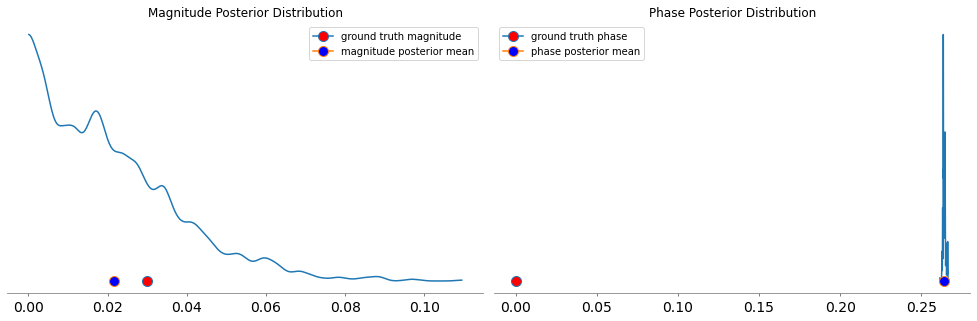

In [43]:
#------------------------------------ load trace and post process---------------------------------------------------
experiment = "test4"
with rotor_model:    
    print('loading trace')
    #trace = pickle.load(open("trace_discrepancy.p", "rb"))
    trace = az.from_netcdf("trace_"+experiment+".nc")
    
    print('summarizing trace')
    print(az.summary(trace, round_to=4))
    print('plotting trace')
    ax1, ax2 = az.plot_posterior(trace, point_estimate = None, hdi_prob = 'hide')
    plt.tight_layout()
    ax1.set_title('Magnitude Posterior Distribution')
    gt_mag, = ax1.plot(0.03,0,marker="o", markersize=10, markerfacecolor="red", label = 'ground truth magnitude')
    pm_mag, = ax1.plot(0.0216,0,marker="o", markersize=10, markerfacecolor="blue", label = 'magnitude posterior mean')
    ax1.legend(handles = [gt_mag, pm_mag])

    
    ax2.set_title('Phase Posterior Distribution')
    gt_phase, = ax2.plot(0,0,marker="o", markersize=10, markerfacecolor="red", label = 'ground truth phase')
    pm_phase, = ax2.plot(0.2642,0,marker="o", markersize=10, markerfacecolor="blue", label = 'phase posterior mean')
    ax2.legend(handles = [gt_phase, pm_phase])

    
    
    # fig = axes.ravel()[0].figure
    # fig.savefig(experiment+".png")

In [14]:
# # Bayesian formulation with discrepancy (second) method

# # solve with bayesian inference, model discrepancy included
# X = FREQUENCY_RANGE.reshape((-1,1))

# discrepancy_gp_model = pm.Model()
# class Blackbox_Model(pm.gp.mean.Mean):
#     def __init__(self, Beta, rotor_model=rotor_sim, obs_node=DISK_NODE):
#         self.Beta = Beta
#         self.rotor_model = rotor_model
#         self.obs_node = DISK_NODE
        

#     def __call__(self, x):
#         # return simulator prediction given theta and X
#         x = x.reshape((-1,))
#         imb_resp_op = RotorModelOp(get_imb_resp=getImbalanceResponse, rotor_model=self.rotor_model, obs_node=self.obs_node, frequency_range=x)
#         return imb_resp_op(Beta)

# print('done')

# with discrepancy_gp_model:
#     # priors on parameters
#     # half-normal distribution may be biasing it to be larger
#     # Priors for unknown model parameters
#     mag_rand = pm.HalfNormal('mag_rand', sigma=0.4) # magnitude is always positive
#     phase_rand = pm.Uniform('phase_rand', lower = 0, upper = 2*math.pi ) # radians

#     Beta = tt.as_tensor_variable([mag_rand, phase_rand])
    
#     # priors for GP covariance
#     length_scale = pm.Bound(pm.Gamma, upper = 4)("length_scale", alpha=5, beta=5) # taken from discrepancy modeling paper
#     eta = pm.HalfCauchy('eta', beta=5)

#     # prior on discrepancy function (zero mean)
#     mean_func = Blackbox_Model(Beta)
#     cov_func = (eta**2) * pm.gp.cov.ExpQuad(1, ls=length_scale)
#     gp = pm.gp.Marginal(mean_func= mean_func, cov_func = cov_func)

#     # discrepancy = gp.prior("discrepancy", X = X)
#     y_ = gp.marginal_likelihood("y", X=X, y=observations, noise = SIGMA_TRUE)

#     # run inference
#     step = pm.Metropolis()
#     #trace = pm.sample(10, tune = 40, step = step, chains = 2, return_inferencedata=True)
#     trace = pm.sample(1000, tune = 4000, step = step, chains = 2, return_inferencedata=True)
    
#     #print(az.summary(trace, round_to=2))

#     plt.show()

In [15]:
(abs(0.0396 - 0.03))

# (abs(0.2642 - 0))

0.009600000000000004

In [16]:
abs(0.02839553- 0.03)

0.0016044700000000002